In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

from pocovidnet import MODEL_FACTORY
from pocovidnet.utils import Metrics

from plots import *
from cross_val_splitter import *
from set_conf_cnn_model import *

### Cargar el dataset

In [2]:
num_folds = 5
data_dir = './image_dataset'
output_dir = './image_cross_val'

In [3]:
#import shutil
#shutil.rmtree(output_dir)
#shutil.rmtree('./trained_models/model_1')

### Dividir el dataset

In [4]:
#set_split_crossval = CrossValSplitter(num_folds, data_dir, output_dir)
#set_split_crossval.split_dataset()
#set_split_crossval.check_crossval(output_dir)

### Visualización de las clases

In [30]:
#classes = ['regular', 'pneumonia', 'covid']

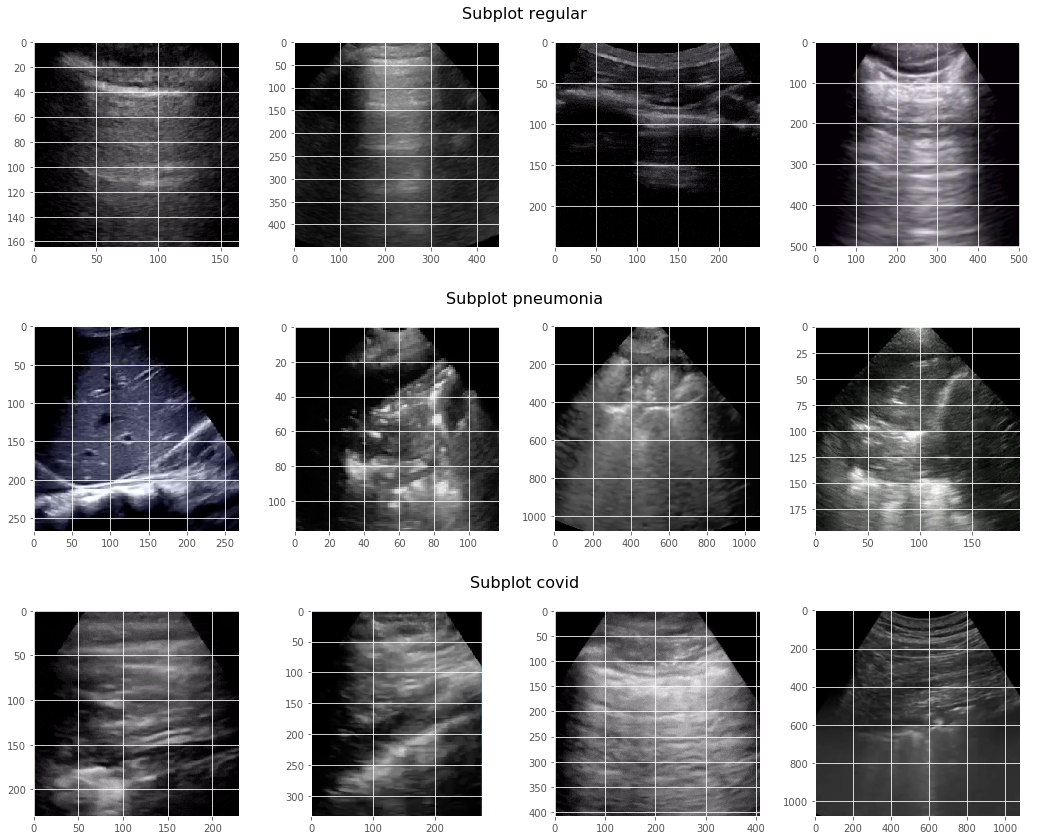

In [34]:
Plots.imgs_dataset(data_dir, classes, 4)

### Definición del modelo

In [7]:
args_model = {
    'data_dir': './image_cross_val',
    'model_name': 'test',
    'model_dir': 'trained_models/model_16',#'models/',
    'model_id': 'vgg_16',
    'fold': 4,
    'learning_rate': 1e-4,
    'epochs': 16,
    'batch_size': 16,
    'trainable_base_layers': 1,
    'img_width': 224,
    'img_height': 224,
    'log_softmax': False,
    'hidden_size': 64
}

In [8]:
vgg_rnn = SetConfModel(args_model)

In [9]:
vgg_rnn.check_model()

Configuración de hiperparámetros:

data_dir: ./image_cross_val
model_name: test
model_dir: trained_models/model_16
model_id: vgg_16
fold: 4
learning_rate: 0.0001
epochs: 16
batch_size: 16
trainable_base_layers: 1
img_width: 224
img_height: 224
log_softmax: False
hidden_size: 64


In [10]:
train_data, test_data, train_labels, test_labels = vgg_rnn.train_test_dataset()

Cargando imágenes...
OK!. 1389 imágenes cargadas
Fold seleccionado: 4

Number of training samples: 1155 
Number of testing samples: 234
Total samples: 1389


In [11]:
classes, trainX, testX, trainY, testY = vgg_rnn.one_hot_encoding(train_data, test_data, train_labels, test_labels)

Class mappings are: ['covid' 'pneumonia' 'regular']


### Aplicando técnicas de regularización

In [12]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [13]:
# Load the VGG16 network
model = MODEL_FACTORY[vgg_rnn.MODEL_ID](
    input_size=(vgg_rnn.IMG_WIDTH, vgg_rnn.IMG_HEIGHT, 3),
    num_classes=len(set(train_labels)),
    trainable_layers=vgg_rnn.TRAINABLE_BASE_LAYERS,
    log_softmax=vgg_rnn.LOG_SOFTMAX,
    hidden_size=vgg_rnn.HIDDEN_SIZE
)

### Callbacks

In [14]:
# Define callbacks
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [15]:
mcp_save = ModelCheckpoint(
    os.path.join(vgg_rnn.MODEL_DIR, 'fold_' + str(vgg_rnn.FOLD) + '_epoch_{epoch:02d}'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [16]:
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=7,
    verbose=1,
    epsilon=1e-4,
    #min_delta=1e-4,
    mode='min'
)

In [17]:
# To show balanced accuracy
metrics = Metrics((testX, testY), model)

In [18]:
vgg_rnn.compile_model(model)

Compiling model...
Model has 14747971 parameters
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool 

In [19]:
H = vgg_rnn.fit_model(model, 
                  trainAug, earlyStopping, mcp_save, reduce_lr_loss, metrics,
                  trainX, testX, trainY, testY)

Starting training model...
Epoch 1/16
72/72 [==============================] - ETA: 0s - loss: 1.1212 - accuracy: 0.5171
Epoch 00001: val_accuracy improved from -inf to 0.40598, saving model to trained_models/model_16/test/_fold_4/fold_4_epoch_01
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: trained_models/model_16/test/_fold_4/fold_4_epoch_01/assets
Balanced accuracy is: {'val_balanced': 0.4937875128092519}
72/72 [==============================] - 101s 1s/step - loss: 1.1212 - accuracy: 0.5171 - val_loss: 0.9945 - val_accuracy: 0.4060 - lr: 1.0000e-04
Epoch 2/16
72/72 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.7006
Epoch 00002: val_accuracy improved from 0.40598 to 0.64103, saving model to trained_models/model_16/test/_fold_4/fold_4_epoch_02
INFO:tensorflow:Assets written to: trained_models/model_16/test/_fold_4/fold_4_epoch_02/assets
Balanced accuracy is: {'val_balanced': 0.659905211535

In [20]:
# make predictions on the testing set
print('Evaluating network...')
predIdxs = model.predict(testX, batch_size=vgg_rnn.BATCH_SIZE)

Evaluating network...


In [21]:
predIdxs_max = np.argmax(predIdxs, axis=1)

print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs_max, target_names=classes
    )
)

classification report sklearn:
              precision    recall  f1-score   support

       covid       0.84      0.99      0.90       144
   pneumonia       0.89      0.36      0.52        44
     regular       0.98      0.98      0.98        46

    accuracy                           0.87       234
   macro avg       0.90      0.78      0.80       234
weighted avg       0.87      0.87      0.85       234



In [26]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
print('confusion matrix:')
cm = confusion_matrix(testY.argmax(axis=1), predIdxs_max)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

confusion matrix:
[[142   1   1]
 [ 28  16   0]
 [  0   1  45]]


Saving COVID-19 detector model on trained_models/model_16/test/_fold_4 data...


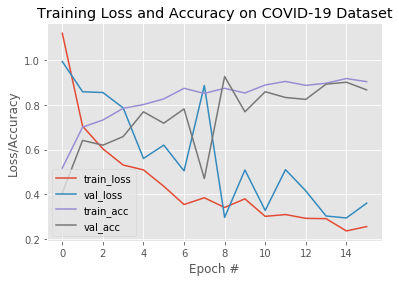

In [27]:
# serialize the model to disk
print(f'Saving COVID-19 detector model on {vgg_rnn.MODEL_DIR} data...')
model.save(os.path.join(vgg_rnn.MODEL_DIR, 'last_epoch'), save_format='h5')

# plot the training loss and accuracy
Plots.train_loss_acc_results(H, vgg_rnn.MODEL_DIR, vgg_rnn.FOLD, vgg_rnn.EPOCHS)